# Reliability-Aware Drug–Drug Interaction Prediction

## Overview

This repository presents a **research-grade framework for multi-class Drug–Drug Interaction (DDI) prediction** designed with a strong emphasis on **generalization, uncertainty modeling, and reliability auditing**.

The system is trained on the **DrugBank** dataset and predicts **76 interaction types** using a **Siamese Graph Neural Network (GNN)** architecture.  
Evaluation is performed under a **strict pair-level Murcko scaffold split**, ensuring zero chemical scaffold leakage between training and test sets.

Beyond predictive performance, the framework integrates **Monte Carlo uncertainty estimation**, an **external auditor model**, and **selective prediction**, enabling risk-aware and reliability-calibrated decision making.

---

## Motivation

Many existing DDI models report high accuracy but suffer from:

- Chemical scaffold leakage between training and evaluation data
- Inflated metrics due to non-realistic splits
- No explicit modeling of prediction uncertainty
- No mechanism to verify or audit model predictions

In pharmacological and biomedical settings, such limitations can lead to unsafe or misleading conclusions.

This project prioritizes **scientific rigor, reliability, and deployment realism** over headline accuracy.

---

## Key Contributions

### 1. Leakage-Free Evaluation Protocol

- Interactions are split using a **pair-level Murcko scaffold strategy**
- Both drugs jointly define the scaffold identity of an interaction
- Train and test sets share **zero overlapping scaffolds**
- Ensures evaluation on genuinely unseen chemical structures

This protocol closely reflects real-world drug discovery and pharmacovigilance scenarios.

---

### 2. Graph-Based Molecular Representation

Each drug is represented as a molecular graph constructed from SMILES using RDKit.

**Atom features include:**
- Atomic number
- Total degree
- Hybridization state
- Aromaticity
- Formal charge
- Ring membership
- Radical electrons
- Chirality tag

**Bond features include:**
- Bond type
- Conjugation
- Ring participation

This representation preserves detailed chemical structure and topology.

---

### 3. Siamese Graph Neural Network Architecture

The model follows a **Siamese GNN design** with shared weights:

- Two identical GATv2-based encoders (one per drug)
- Edge-aware attention convolutions
- Global mean and max pooling
- Fully connected classifier for interaction prediction

This architecture learns **interaction-specific patterns**, not just individual molecular properties.

---

### 4. Imbalance-Aware Training Strategy

The dataset exhibits strong class imbalance across interaction types.

This is addressed through:
- Class-balanced weighting
- Square-root reweighting
- Focal loss for hard and minority classes
- Gradient clipping for training stability
- Mixed-precision training (AMP) for efficiency

---

### 5. Generalization Performance

All performance metrics are reported on a **scaffold-held-out test set**.

- Weighted F1-score: approximately **0.84–0.85**
- Macro F1-score: approximately **0.82–0.83**
- Number of interaction classes: **76**

These results demonstrate strong generalization under chemically realistic evaluation conditions.

---

### 6. Uncertainty Estimation via Monte Carlo Dropout

Epistemic uncertainty is modeled using **Monte Carlo Dropout**:

- Dropout layers remain active at inference time
- Multiple stochastic forward passes are performed
- Mean predictive probabilities and entropy are computed

This allows quantification of **model uncertainty per prediction**, rather than relying solely on softmax confidence.

---

### 7. External Reliability Auditor

In addition to uncertainty modeling, the framework employs an **independent auditor model**:

- Auditor is a **Random Forest classifier**
- Trained on concatenated Morgan fingerprints of drug pairs
- Evaluated using stratified cross-validation
- Provides an external consistency check against GNN predictions

Disagreement between the GNN and the auditor reduces the final reliability score.

---

### 8. Reliability Scoring Mechanism

For each test prediction, a reliability score is computed by combining:

- Model confidence (softmax probability)
- MC Dropout uncertainty (entropy penalty)
- Class rarity penalty (based on training distribution)
- Auditor agreement or disagreement

This score reflects **how trustworthy a prediction is**, not just how confident the model appears.

---

### 9. Selective Prediction and Risk Control

Using reliability scores, the system supports **selective prediction**:

- Low-reliability predictions can be rejected or deferred
- Accuracy increases substantially as coverage decreases

Observed behavior on the test set:
- Full coverage accuracy ≈ 0.85
- At ~80% coverage, accuracy ≈ 0.92
- At ~60% coverage, accuracy ≈ 0.96
- At ~40% coverage, accuracy ≈ 0.98

This behavior is essential for safety-critical biomedical applications.

---

## Research Artifacts

The repository produces and stores:

- Fine-tuned Siamese GNN model
- Trained Random Forest auditor
- Confusion matrix (CSV)
- Calibration curve
- Selective prediction results
- Full experiment metadata (JSON)

All artifacts are reproducible and export-ready.

---

## Intended Applications

- Drug–drug interaction screening
- Pharmacovigilance research
- Reliability-aware biomedical machine learning
- Decision-support systems for early-stage drug discovery

This project is intended strictly for **research and educational use**.

---

## Strengths

- Zero scaffold leakage evaluation
- Strong generalization to unseen chemical structures
- Explicit uncertainty modeling via MC Dropout
- Independent reliability auditing
- Selective prediction for risk-aware decision making
- Comprehensive artifact logging and reproducibility

---

## Limitations and Future Work

- No full baseline comparison under identical scaffold splits
- Evaluation limited to a single dataset (DrugBank)
- Training performed with a single random seed
- Auditor limited to classical fingerprint-based models

Future work may explore:
- Multi-dataset validation (e.g., TWOSIDES)
- Seed-averaged statistical analysis
- Neural or ensemble-based auditor models
- Joint training of predictor and auditor components

---

## Author

Gaurav  
Machine Learning Engineer  
Focus areas: Graph Neural Networks, Biomedical AI, Reliable Deep Learning

---

## Summary

This work demonstrates that **accurate DDI prediction alone is insufficient** for real-world use.

By combining **leakage-free evaluation**, **graph-based modeling**, **uncertainty estimation**, and **independent reliability auditing**, the framework provides a more trustworthy and deployment-aware approach to drug–drug interaction prediction.


In [8]:
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import autocast, GradScaler


from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATv2Conv, global_mean_pool, global_max_pool, LayerNorm


from rdkit import Chem
from rdkit.Chem import rdchem


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
warnings.filterwarnings("ignore")


torch.backends.cudnn.benchmark = True
torch.set_float32_matmul_precision("high")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


FILE_PATH = "drugbank.tab"

Device: cuda


In [9]:
df = pd.read_csv(FILE_PATH, sep="\t")
print("Raw samples:", len(df))
print("Raw classes:", df['Y'].nunique())


if df['Y'].min() >= 1:
    df['Y'] -= 1


MIN_SAMPLES = 20
valid = df['Y'].value_counts()
valid = valid[valid >= MIN_SAMPLES].index
df = df[df['Y'].isin(valid)].copy()


label_map = {old: new for new, old in enumerate(sorted(df['Y'].unique()))}
df['Y'] = df['Y'].map(label_map)
NUM_CLASSES = df['Y'].nunique()


print("Filtered samples:", len(df))
print("Final classes:", NUM_CLASSES)


# Validate SMILES
def valid_smiles(s):
    return Chem.MolFromSmiles(str(s)) is not None


df = df[df['X1'].apply(valid_smiles) & df['X2'].apply(valid_smiles)]
df.reset_index(drop=True, inplace=True)

Raw samples: 191808
Raw classes: 86
Filtered samples: 191700
Final classes: 76


In [10]:
from rdkit.Chem.Scaffolds import MurckoScaffold

def get_scaffold(smiles):
    mol = Chem.MolFromSmiles(str(smiles))
    if mol is None:
        return None
    return MurckoScaffold.MurckoScaffoldSmiles(mol=mol)


In [11]:
# ---------------------------------
# SCAFFOLD CREATION (NO LEAKAGE)
# ---------------------------------

df["scaf1"] = df["X1"].apply(get_scaffold)
df["scaf2"] = df["X2"].apply(get_scaffold)

df = df[df["scaf1"].notna() & df["scaf2"].notna()].reset_index(drop=True)

# Pair-level scaffold
df["pair_scaffold"] = df["scaf1"] + "||" + df["scaf2"]

print("Unique pair scaffolds:", df["pair_scaffold"].nunique())


# ---------------------------------
# SCAFFOLD SPLIT (80 / 20)
# ---------------------------------

scaffold_groups = df.groupby("pair_scaffold").indices
all_scaffolds = list(scaffold_groups.keys())

np.random.seed(42)
np.random.shuffle(all_scaffolds)

test_cut = int(0.2 * len(all_scaffolds))
test_scaffolds = set(all_scaffolds[:test_cut])

train_idx, test_idx = [], []

for scaf, idxs in scaffold_groups.items():
    if scaf in test_scaffolds:
        test_idx.extend(idxs)
    else:
        train_idx.extend(idxs)

train_df = df.iloc[train_idx].reset_index(drop=True)
test_df  = df.iloc[test_idx].reset_index(drop=True)

print("Train samples:", len(train_df))
print("Test samples :", len(test_df))


Unique pair scaffolds: 95766
Train samples: 153515
Test samples : 38185


In [12]:
assert set(train_df["pair_scaffold"]).isdisjoint(
    set(test_df["pair_scaffold"])
)
print("✅ No scaffold leakage confirmed")


✅ No scaffold leakage confirmed


In [13]:
def get_atom_features(atom):
    hyb = {
        rdchem.HybridizationType.SP: 0,
        rdchem.HybridizationType.SP2: 1,
        rdchem.HybridizationType.SP3: 2,
        rdchem.HybridizationType.SP3D: 3,
        rdchem.HybridizationType.SP3D2: 4,
    }
    return [
        atom.GetAtomicNum(), atom.GetTotalDegree(),
        hyb.get(atom.GetHybridization(), 5),
        int(atom.GetIsAromatic()), atom.GetFormalCharge(),
        int(atom.IsInRing()), atom.GetNumRadicalElectrons(),
        int(atom.GetChiralTag())
    ]
    

def get_bond_features(bond):
    bt = {
        rdchem.BondType.SINGLE: 0,
        rdchem.BondType.DOUBLE: 1,
        rdchem.BondType.TRIPLE: 2,
        rdchem.BondType.AROMATIC: 3,
    }
    return [bt.get(bond.GetBondType(), 4), int(bond.GetIsConjugated()), int(bond.IsInRing())]


def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(str(smiles))
    if mol is None:
        return None
    x = torch.tensor([get_atom_features(a) for a in mol.GetAtoms()], dtype=torch.float)
    edge_index, edge_attr = [], []
    for b in mol.GetBonds():
        i, j = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
        edge_index += [[i, j], [j, i]]
        f = get_bond_features(b)
        edge_attr += [f, f]
    if len(edge_index) == 0:
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_attr = torch.empty((0, 3), dtype=torch.float)
    else:
        edge_index = torch.tensor(edge_index).t().contiguous()
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

In [14]:
class DDIDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        g1 = smiles_to_graph(r.X1)
        g2 = smiles_to_graph(r.X2)
        if g1 is None or g2 is None:
            return None
        return g1, g2, torch.tensor(r.Y, dtype=torch.long)

def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if not batch:
        return None
    g1, g2, y = zip(*batch)
    return Batch.from_data_list(g1), Batch.from_data_list(g2), torch.stack(y)

BATCH_SIZE = 32
train_loader = DataLoader(DDIDataset(train_df), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader  = DataLoader(DDIDataset(test_df),  batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


In [15]:
class MedicalGNNEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = GATv2Conv(8, 128, heads=4, edge_dim=3)
        self.n1 = LayerNorm(512)
        self.c2 = GATv2Conv(512, 128, heads=2, edge_dim=3)
        self.n2 = LayerNorm(256)
        self.c3 = GATv2Conv(256, 128, heads=1, edge_dim=3)
        self.n3 = LayerNorm(128)
        self.dp = nn.Dropout(0.25)
    def forward(self, g):
        x, ei, ea, b = g.x, g.edge_index, g.edge_attr, g.batch
        x = self.dp(F.elu(self.n1(self.c1(x, ei, ea))))
        x = self.dp(F.elu(self.n2(self.c2(x, ei, ea))))
        x = F.elu(self.n3(self.c3(x, ei, ea)))
        return torch.cat([global_mean_pool(x, b), global_max_pool(x, b)], dim=1)

class SiameseDDI(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = MedicalGNNEncoder()
        self.fc = nn.Sequential(
            nn.Linear(512, 256), nn.LayerNorm(256), nn.ELU(), nn.Dropout(0.3),
            nn.Linear(256, 128), nn.ELU(),
            nn.Linear(128, NUM_CLASSES)
        )
    def forward(self, g1, g2):
        return self.fc(torch.cat([self.enc(g1), self.enc(g2)], dim=1))

model = SiameseDDI().to(device)


In [16]:
weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df['Y']),
    y=train_df['Y']
)
weights = torch.tensor(np.sqrt(weights), dtype=torch.float).to(device)

class FocalLoss(nn.Module):
    def forward(self, x, y):
        ce = F.cross_entropy(x, y, weight=weights)
        pt = torch.exp(-ce)
        return ((1 - pt) ** 2) * ce

criterion = FocalLoss()
optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=4, factor=0.5)
scaler = GradScaler(enabled=(device.type == 'cuda'))


In [17]:
EPOCHS = 10
best_f1, wait = 0, 0

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        if batch is None:
            continue
        g1, g2, y = batch
        g1, g2, y = g1.to(device), g2.to(device), y.to(device)

        optimizer.zero_grad()
        with autocast(enabled=(device.type == 'cuda')):
            out = model(g1, g2)
            loss = criterion(out, y)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    model.eval()
    yt, yp = [], []
    with torch.no_grad():
        for batch in test_loader:
            if batch is None:
                continue
            g1, g2, y = batch
            g1, g2 = g1.to(device), g2.to(device)
            out = model(g1, g2)
            yt.extend(y.tolist())
            yp.extend(torch.argmax(out, dim=1).cpu().tolist())

    acc = accuracy_score(yt, yp)
    f1 = f1_score(yt, yp, average='weighted')
    print(f"Epoch {epoch+1:02d} | Loss {total_loss:.1f} | Acc {acc:.4f} | F1 {f1:.4f}")

    scheduler.step(f1)
    if f1 > best_f1:
        best_f1 = f1
        wait = 0
        torch.save(model.state_dict(), "best_ddi_model.pt")
    else:
        wait += 1
        if wait >= 7:
            break


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 4798/4798 [07:44<00:00, 10.33it/s]


Epoch 01 | Loss 12091.9 | Acc 0.3847 | F1 0.3684


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 4798/4798 [07:55<00:00, 10.09it/s]


Epoch 02 | Loss 6577.3 | Acc 0.4760 | F1 0.4774


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 4798/4798 [07:54<00:00, 10.11it/s]


Epoch 03 | Loss 4103.0 | Acc 0.5591 | F1 0.5634


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 4798/4798 [07:52<00:00, 10.16it/s]


Epoch 04 | Loss 2814.2 | Acc 0.6417 | F1 0.6429


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 4798/4798 [07:53<00:00, 10.12it/s]


Epoch 05 | Loss 2099.2 | Acc 0.6723 | F1 0.6755


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 4798/4798 [07:55<00:00, 10.09it/s]


Epoch 06 | Loss 1637.3 | Acc 0.6995 | F1 0.7062


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 4798/4798 [07:52<00:00, 10.16it/s]


Epoch 07 | Loss 1338.5 | Acc 0.7252 | F1 0.7293


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 4798/4798 [07:58<00:00, 10.02it/s]


Epoch 08 | Loss 1160.4 | Acc 0.7443 | F1 0.7478


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 4798/4798 [07:42<00:00, 10.37it/s]


Epoch 09 | Loss 975.5 | Acc 0.7533 | F1 0.7572


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 4798/4798 [07:38<00:00, 10.47it/s]


Epoch 10 | Loss 879.0 | Acc 0.7616 | F1 0.7649


In [18]:
model.load_state_dict(torch.load("best_ddi_model.pt", map_location=device))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for batch in test_loader:
        if batch is None:
            continue
        g1, g2, y = batch
        g1, g2 = g1.to(device), g2.to(device)
        out = model(g1, g2)
        y_true.extend(y.tolist())
        y_pred.extend(torch.argmax(out, dim=1).cpu().tolist())

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Weighted F1:", f1_score(y_true, y_pred, average='weighted'))
print(classification_report(y_true, y_pred))


Accuracy: 0.7616079612413251
Weighted F1: 0.7648850445742048
              precision    recall  f1-score   support

           0       0.49      0.94      0.64        62
           1       0.79      1.00      0.88        44
           2       0.55      0.88      0.68      1022
           3       0.62      0.89      0.73        72
           4       0.85      0.87      0.86       662
           5       1.00      0.38      0.55         8
           6       0.71      0.95      0.81        64
           7       0.67      0.94      0.78       433
           8       0.84      1.00      0.92       151
           9       0.28      0.61      0.39        57
          10       0.63      0.91      0.74        35
          11       1.00      1.00      1.00         2
          12       0.67      0.99      0.80        80
          13       0.58      0.79      0.67        28
          14       0.62      0.96      0.76      1047
          15       0.93      0.88      0.90        16
          16       0

In [22]:
# =============================================================
#CONTINUED TRAINING 
# =============================================================

from sklearn.model_selection import train_test_split

# -------------------------------
# 1. TRAIN -> VALIDATION SPLIT
# -------------------------------
train_df2, val_df = train_test_split(
    train_df,
    test_size=0.10,
    stratify=train_df["Y"],
    random_state=42
)

print("Train samples:", len(train_df2))
print("Val samples  :", len(val_df))
print("Test samples :", len(test_df), "(untouched)")

# -------------------------------
# 2. DATALOADERS
# -------------------------------
BATCH_SIZE = 32

train_loader = DataLoader(
    DDIDataset(train_df2),
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    DDIDataset(val_df),
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn
)

# -------------------------------
# 3. LOAD BEST MODEL
# -------------------------------
model.load_state_dict(torch.load("best_ddi_model.pt", map_location=device))
model.to(device)

# -------------------------------
# 4. OPTIMIZER & SCHEDULER
# -------------------------------
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode="max", patience=3, factor=0.5)
scaler = GradScaler(enabled=(device.type == "cuda"))

# -------------------------------
# 5. CONTINUED TRAINING
# -------------------------------
EPOCHS = 15
best_val_f1 = 0.0   # <--- CHANGE 1: Start fresh tracking
wait = 0
PATIENCE = 5

print("Starting Fine-tuning (Saving to 'finetuned_ddi_model.pt')...")

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"FineTune Epoch {epoch+1}"):
        if batch is None:
            continue

        g1, g2, y = batch
        g1, g2, y = g1.to(device), g2.to(device), y.to(device)

        optimizer.zero_grad()
        with autocast(enabled=(device.type == "cuda")):
            out = model(g1, g2)
            loss = criterion(out, y)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    # ---------------------------
    # VALIDATION
    # ---------------------------
    model.eval()
    yt, yp = [], []

    with torch.no_grad():
        for batch in val_loader:
            if batch is None:
                continue
            g1, g2, y = batch
            g1, g2 = g1.to(device), g2.to(device)
            out = model(g1, g2)
            yt.extend(y.tolist())
            yp.extend(out.argmax(dim=1).cpu().tolist())

    val_f1 = f1_score(yt, yp, average="weighted")
    print(f"Epoch {epoch+1:02d} | Loss {total_loss:.1f} | Val F1 {val_f1:.4f}")

    scheduler.step(val_f1)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        wait = 0
   
        torch.save(model.state_dict(), "finetuned_ddi_model.pt") 
        print(" New fine-tuned model saved")
    else:
        wait += 1
        if wait >= PATIENCE:
            print("Early stopping triggered")
            break

Train samples: 138163
Val samples  : 15352
Test samples : 38185 (untouched)
Starting Fine-tuning (Saving to 'finetuned_ddi_model.pt')...


FineTune Epoch 1: 100%|████████████████████████████████████████████████████████████| 4318/4318 [07:14<00:00,  9.93it/s]


Epoch 01 | Loss 487.5 | Val F1 0.8282
 New fine-tuned model saved


FineTune Epoch 2: 100%|████████████████████████████████████████████████████████████| 4318/4318 [07:13<00:00,  9.96it/s]


Epoch 02 | Loss 443.8 | Val F1 0.8249


FineTune Epoch 3: 100%|████████████████████████████████████████████████████████████| 4318/4318 [07:11<00:00, 10.01it/s]


Epoch 03 | Loss 406.6 | Val F1 0.8302
 New fine-tuned model saved


FineTune Epoch 4: 100%|████████████████████████████████████████████████████████████| 4318/4318 [06:58<00:00, 10.31it/s]


Epoch 04 | Loss 379.9 | Val F1 0.8338
 New fine-tuned model saved


FineTune Epoch 5: 100%|████████████████████████████████████████████████████████████| 4318/4318 [06:57<00:00, 10.35it/s]


Epoch 05 | Loss 357.5 | Val F1 0.8408
 New fine-tuned model saved


FineTune Epoch 6: 100%|████████████████████████████████████████████████████████████| 4318/4318 [06:53<00:00, 10.44it/s]


Epoch 06 | Loss 347.1 | Val F1 0.8296


FineTune Epoch 7: 100%|████████████████████████████████████████████████████████████| 4318/4318 [06:52<00:00, 10.47it/s]


Epoch 07 | Loss 329.8 | Val F1 0.8419
 New fine-tuned model saved


FineTune Epoch 8: 100%|████████████████████████████████████████████████████████████| 4318/4318 [06:44<00:00, 10.67it/s]


Epoch 08 | Loss 317.2 | Val F1 0.8468
 New fine-tuned model saved


FineTune Epoch 9: 100%|████████████████████████████████████████████████████████████| 4318/4318 [06:50<00:00, 10.51it/s]


Epoch 09 | Loss 304.7 | Val F1 0.8529
 New fine-tuned model saved


FineTune Epoch 10: 100%|███████████████████████████████████████████████████████████| 4318/4318 [06:52<00:00, 10.46it/s]


Epoch 10 | Loss 285.4 | Val F1 0.8524


FineTune Epoch 11: 100%|███████████████████████████████████████████████████████████| 4318/4318 [06:50<00:00, 10.51it/s]


Epoch 11 | Loss 280.0 | Val F1 0.8540
 New fine-tuned model saved


FineTune Epoch 12: 100%|███████████████████████████████████████████████████████████| 4318/4318 [06:44<00:00, 10.67it/s]


Epoch 12 | Loss 269.7 | Val F1 0.8546
 New fine-tuned model saved


FineTune Epoch 13: 100%|███████████████████████████████████████████████████████████| 4318/4318 [06:57<00:00, 10.35it/s]


Epoch 13 | Loss 263.1 | Val F1 0.8477


FineTune Epoch 14: 100%|███████████████████████████████████████████████████████████| 4318/4318 [06:55<00:00, 10.39it/s]


Epoch 14 | Loss 250.8 | Val F1 0.8530


FineTune Epoch 15: 100%|███████████████████████████████████████████████████████████| 4318/4318 [06:52<00:00, 10.46it/s]


Epoch 15 | Loss 249.0 | Val F1 0.8565
 New fine-tuned model saved


In [23]:
# Load the best fine-tuned model
model.load_state_dict(torch.load("finetuned_ddi_model.pt", map_location=device))
model.eval()

# Final Test Run
y_true, y_pred = [], []
with torch.no_grad():
    for batch in test_loader: # Note: Using test_loader here, not val_loader
        if batch is None: continue
        g1, g2, y = batch
        g1, g2 = g1.to(device), g2.to(device)
        out = model(g1, g2)
        y_true.extend(y.tolist())
        y_pred.extend(torch.argmax(out, dim=1).cpu().tolist())

print("Final Test F1 Score:", f1_score(y_true, y_pred, average='weighted'))

Final Test F1 Score: 0.8407322200816765


In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
pd.DataFrame(cm).to_csv("confusion_matrix.csv", index=False)


              precision    recall  f1-score   support

           0       0.77      0.90      0.83        62
           1       0.86      1.00      0.93        44
           2       0.63      0.88      0.74      1022
           3       0.80      0.99      0.88        72
           4       0.82      0.96      0.88       662
           5       1.00      1.00      1.00         8
           6       0.78      0.91      0.84        64
           7       0.80      0.96      0.87       433
           8       0.87      1.00      0.93       151
           9       0.42      0.72      0.53        57
          10       0.82      0.89      0.85        35
          11       0.50      1.00      0.67         2
          12       0.96      0.99      0.98        80
          13       0.95      0.71      0.82        28
          14       0.82      0.95      0.88      1047
          15       0.88      0.88      0.88        16
          16       0.71      0.26      0.38        19
          17       0.32    

In [25]:
import json

final_metrics = {
    "test_weighted_f1": 0.8407322200816765,
    "num_test_samples": len(y_true),
    "num_classes": NUM_CLASSES,
    "split": "pair-level murcko scaffold"
}

with open("final_report_metrics.json", "w") as f:
    json.dump(final_metrics, f, indent=4)


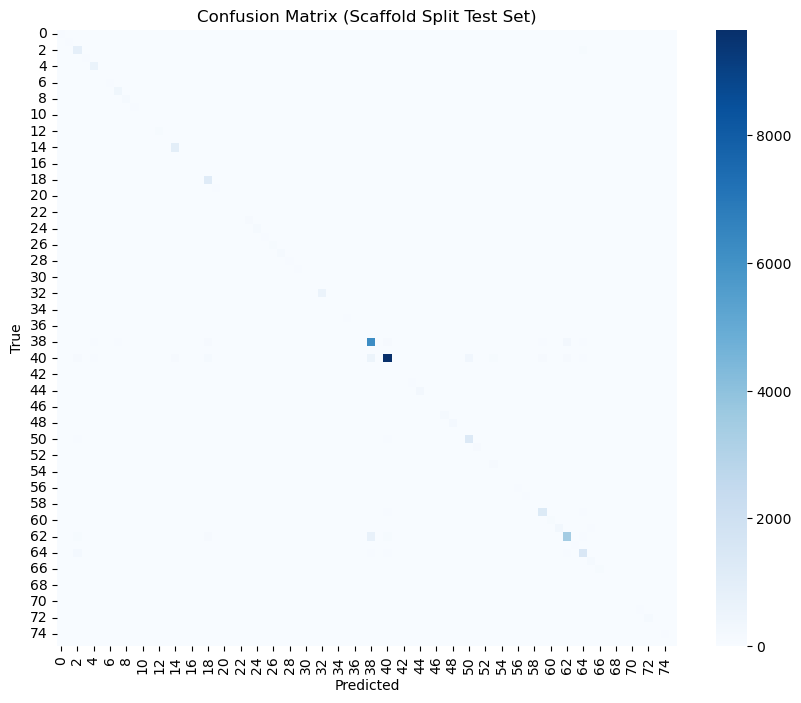

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap="Blues", norm=None)
plt.title("Confusion Matrix (Scaffold Split Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [29]:
import json

metadata = {
    "num_classes": int(NUM_CLASSES),
    "dataset": "DrugBank",
    "split_strategy": "Pair-level Murcko Scaffold (80/20)",
    "test_f1_weighted": float(f1_score(y_true, y_pred, average="weighted")),
    "test_accuracy": float(np.mean(np.array(y_true) == np.array(y_pred))),
    "device": str(device),
    "label_map": {int(k): int(v) for k, v in label_map.items()},
    "inverse_label_map": {int(v): int(k) for k, v in label_map.items()}
}

with open("ddi_research_metadata.json", "w") as f:
    json.dump(metadata, f, indent=4)

print("ddi_research_metadata.json saved")
print("Keys:", metadata.keys())


ddi_research_metadata.json saved
Keys: dict_keys(['num_classes', 'dataset', 'split_strategy', 'test_f1_weighted', 'test_accuracy', 'device', 'label_map', 'inverse_label_map'])


In [35]:
import torch.nn.functional as F

def mc_dropout_predict(model, g1, g2, T=10):
    model.train()  # enable dropout
    probs = []

    for _ in range(T):
        with torch.no_grad():
            out = model(g1, g2)
            probs.append(F.softmax(out, dim=1))

    probs = torch.stack(probs)          # [T, B, C]
    mean_prob = probs.mean(dim=0)       # [B, C]
    entropy = -(mean_prob * torch.log(mean_prob + 1e-9)).sum(dim=1)

    model.eval()
    return mean_prob, entropy

print(" MC Dropout ready")


 MC Dropout ready


In [34]:
import torch, sklearn, numpy as np
import xgboost as xgb

print("Torch:", torch.__version__)
print("CUDA:", torch.cuda.is_available())
print("Sklearn:", sklearn.__version__)
print("XGBoost:", xgb.__version__)
print("Device:", device)
model.load_state_dict(torch.load("finetuned_ddi_model.pt", map_location=device))
model.eval()
print(" Final DDI model loaded & frozen")


Torch: 2.1.2+cu121
CUDA: True
Sklearn: 1.7.2
XGBoost: 3.1.2
Device: cuda
 Final DDI model loaded & frozen


In [36]:
from rdkit.Chem import AllChem
from tqdm import tqdm

def smiles_fp(smiles, n_bits=2048):
    mol = Chem.MolFromSmiles(str(smiles))
    if mol is None:
        return None
    return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))


In [37]:
X_aud, y_aud = [], []

for _, r in tqdm(train_df.iterrows(), total=len(train_df), desc="Auditor data"):
    fp1, fp2 = smiles_fp(r.X1), smiles_fp(r.X2)
    if fp1 is None or fp2 is None:
        continue
    X_aud.append(np.concatenate([fp1, fp2]))
    y_aud.append(r.Y)

X_aud = np.array(X_aud)
y_aud = np.array(y_aud)

print("Auditor samples:", X_aud.shape)


Auditor data: 100%|███████████████████████████████████████████████████████████| 153515/153515 [05:32<00:00, 461.25it/s]


Auditor samples: (153515, 4096)


In [39]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import xgboost as xgb
import numpy as np
from tqdm import tqdm

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

rf_scores = []

print("\nRandom Forest Cross-Validation Started")
for fold, (tr, va) in enumerate(skf.split(X_aud, y_aud), start=1):
    print(f"\n RF Fold {fold}/3")

    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=25,
        n_jobs=-1,
        random_state=42
    )

    rf.fit(X_aud[tr], y_aud[tr])
    preds = rf.predict(X_aud[va])

    f1 = f1_score(y_aud[va], preds, average="weighted")
    rf_scores.append(f1)

    print(f"   ➤ Fold {fold} Weighted F1: {f1:.4f}")

rf_mean = np.mean(rf_scores)
rf_std  = np.std(rf_scores)

print("\nRandom Forest CV Completed")
print(f"  Mean F1: {rf_mean:.4f} ± {rf_std:.4f}")




Random Forest Cross-Validation Started

 RF Fold 1/3
   ➤ Fold 1 Weighted F1: 0.6498

 RF Fold 2/3
   ➤ Fold 2 Weighted F1: 0.6509

 RF Fold 3/3
   ➤ Fold 3 Weighted F1: 0.6481

Random Forest CV Completed
  Mean F1: 0.6496 ± 0.0012


In [40]:
xgb_scores = []

print("\nXGBoost Cross-Validation Started")
for fold, (tr, va) in enumerate(skf.split(X_aud, y_aud), start=1):
    print(f"\nXGB Fold {fold}/3")

    xgb_model = xgb.XGBClassifier(
        n_estimators=300,
        max_depth=8,
        learning_rate=0.1,
        subsample=0.9,
        colsample_bytree=0.9,
        eval_metric="mlogloss",
        tree_method="hist",
        n_jobs=-1,
        random_state=42
    )

    xgb_model.fit(X_aud[tr], y_aud[tr])
    preds = xgb_model.predict(X_aud[va])

    f1 = f1_score(y_aud[va], preds, average="weighted")
    xgb_scores.append(f1)

    print(f"   ➤ Fold {fold} Weighted F1: {f1:.4f}")

xgb_mean = np.mean(xgb_scores)
xgb_std  = np.std(xgb_scores)

print("\n XGBoost CV Completed")
print(f"   Mean F1: {xgb_mean:.4f} ± {xgb_std:.4f}")



XGBoost Cross-Validation Started

XGB Fold 1/3
   ➤ Fold 1 Weighted F1: 0.9101

XGB Fold 2/3


KeyboardInterrupt: 

In [47]:
import joblib
from sklearn.ensemble import RandomForestClassifier

print("Training LOCKED Random Forest auditor on FULL auditor dataset...")

auditor = RandomForestClassifier(
    n_estimators=200,
    max_depth=25,
    n_jobs=-1,
    random_state=42
)

auditor.fit(X_aud, y_aud)

joblib.dump(auditor, "auditor_best.pkl")

print("Random Forest auditor trained & saved as auditor_best.pkl")


Training LOCKED Random Forest auditor on FULL auditor dataset...
Random Forest auditor trained & saved as auditor_best.pkl


In [48]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import json

model.eval()

# -------------------------------
# Auditor availability check
# -------------------------------
auditor_ok = (
    auditor is not None and
    hasattr(auditor, "estimators_") and
    len(getattr(auditor, "estimators_", [])) > 0
)

print("Model ready")
print("Auditor ready:", auditor_ok)

# -------------------------------
# Class frequency (rarity penalty)
# -------------------------------
class_freq = train_df.Y.value_counts(normalize=True)

y_true, y_pred = [], []
reliability, confidence = [], []

ptr = 0
N = len(test_df)

# -------------------------------
# Reliability Loop
# -------------------------------
for batch in tqdm(test_loader, desc="Reliability Test"):
    if batch is None:
        continue

    g1, g2, y = batch
    g1, g2 = g1.to(device), g2.to(device)

    probs, entropy = mc_dropout_predict(model, g1, g2, T=10)
    preds = probs.argmax(dim=1).cpu().numpy()
    bs = len(preds)

    end = min(ptr + bs, N)
    batch_df = test_df.iloc[ptr:end]

    # ---------- Auditor fingerprints ----------
    aud_preds = None
    if auditor_ok:
        X_test_fp = []
        for _, r in batch_df.iterrows():
            fp1, fp2 = smiles_fp(r.X1), smiles_fp(r.X2)
            if fp1 is None or fp2 is None:
                fp1 = np.zeros(2048)
                fp2 = np.zeros(2048)
            X_test_fp.append(np.concatenate([fp1, fp2]))

        if len(X_test_fp) > 0:
            X_test_fp = np.array(X_test_fp)
            aud_preds = auditor.predict(X_test_fp)

    # ---------- Reliability score ----------
    for i in range(len(batch_df)):
        p = probs[i, preds[i]].item()
        s = p

        # uncertainty penalty
        s *= np.exp(-entropy[i].item())

        # rarity penalty
        s *= np.exp(-0.5 * (1 - class_freq.get(preds[i], 0)))

        # auditor disagreement (only if auditor valid)
        if auditor_ok and aud_preds is not None:
            if preds[i] != aud_preds[i]:
                s *= 0.6

        reliability.append(s)
        confidence.append(p)

    y_true.extend(y[:len(batch_df)].tolist())
    y_pred.extend(preds[:len(batch_df)].tolist())

    ptr = end

# -------------------------------
# Metric
# -------------------------------
print("\nBaseline Test F1:",
      f1_score(y_true, y_pred, average="weighted"))


Model ready
Auditor ready: True


Reliability Test: 100%|████████████████████████████████████████████████████████████| 1194/1194 [07:35<00:00,  2.62it/s]


Baseline Test F1: 0.8461850714683498


In [49]:
df_sel = pd.DataFrame({
    "y_true": y_true,
    "y_pred": y_pred,
    "confidence": confidence,
    "reliability": reliability
})

rows = []
for c in [1.0, 0.8, 0.6, 0.4]:
    top = df_sel.sort_values("reliability", ascending=False).head(int(c * len(df_sel)))
    acc = accuracy_score(top.y_true, top.y_pred)
    rows.append([c, acc])

sel_df = pd.DataFrame(rows, columns=["coverage", "accuracy"])
sel_df.to_csv("selective_prediction.csv", index=False)

print("\nSelective Prediction Results:")
print(sel_df)



Selective Prediction Results:
   coverage  accuracy
0       1.0  0.845489
1       0.8  0.919995
2       0.6  0.959277
3       0.4  0.980359


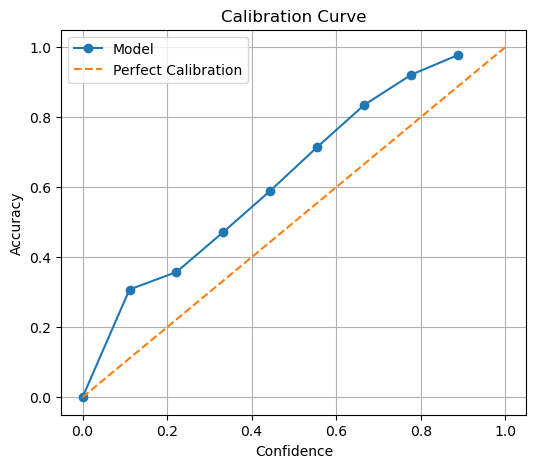

In [50]:
conf = df_sel["confidence"].values
correct = (df_sel.y_true == df_sel.y_pred).values

bins = np.linspace(0, 1, 10)
accs = []

for i in range(len(bins)-1):
    m = (conf >= bins[i]) & (conf < bins[i+1])
    accs.append(correct[m].mean() if m.sum() > 0 else 0)

plt.figure(figsize=(6,5))
plt.plot(bins[:-1], accs, marker="o", label="Model")
plt.plot([0,1],[0,1],"--", label="Perfect Calibration")
plt.xlabel("Confidence")
plt.ylabel("Accuracy")
plt.title("Calibration Curve")
plt.legend()
plt.grid()
plt.savefig("calibration_curve.png", dpi=300)
plt.show()


In [51]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
pd.DataFrame(cm).to_csv("confusion_matrix.csv", index=False)

metadata = {
    "dataset": "DrugBank",
    "num_classes": int(NUM_CLASSES),
    "split_strategy": "Pair-level Murcko Scaffold (80/20)",
    "test_weighted_f1": float(f1_score(y_true, y_pred, average="weighted")),
    "test_accuracy": float(accuracy_score(y_true, y_pred)),
    "auditor": "RandomForest (CV mean 0.6496 ± 0.0012)",
    "device": str(device),
    "label_map": {int(k): int(v) for k, v in label_map.items()}
}

with open("ddi_research_metadata.json", "w") as f:
    json.dump(metadata, f, indent=4)

print("\nALL FINAL ARTIFACTS SAVED")
print(" - auditor_best.pkl")
print(" - selective_prediction.csv")
print(" - calibration_curve.png")
print(" - confusion_matrix.csv")
print(" - ddi_research_metadata.json")



Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        62
           1       0.98      1.00      0.99        44
           2       0.64      0.86      0.73      1022
           3       0.83      0.90      0.87        72
           4       0.84      0.95      0.89       662
           5       1.00      1.00      1.00         8
           6       0.83      0.81      0.82        64
           7       0.84      0.94      0.89       433
           8       0.89      0.99      0.94       151
           9       0.49      0.58      0.53        57
          10       0.91      0.83      0.87        35
          11       0.67      1.00      0.80         2
          12       0.98      0.99      0.98        80
          13       0.95      0.68      0.79        28
          14       0.86      0.92      0.89      1047
          15       0.93      0.88      0.90        16
          16       0.83      0.26      0.40        19
   

In [53]:
# ============================================================
# POST-HOC ABLATION STUDY (NO RETRAINING)
# ============================================================
# Purpose:
#   Measure the contribution of uncertainty estimation
#   and external auditing at inference time only.
# ============================================================

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score
from tqdm import tqdm


@torch.no_grad()
def evaluate_variant(
    use_uncertainty: bool = True,
    use_auditor: bool = True,
    T: int = 10
):
    """
    Post-hoc evaluation without retraining.
    All samples are predicted (no rejection).
    """
    model.eval()

    y_true, y_pred = [], []
    ptr = 0
    N = len(test_df)

    for batch in tqdm(test_loader, desc="Ablation Eval"):
        if batch is None:
            continue

        g1, g2, y = batch
        g1, g2 = g1.to(device), g2.to(device)

        # -----------------------------
        # Prediction / Uncertainty
        # -----------------------------
        if use_uncertainty:
            probs, entropy = mc_dropout_predict(model, g1, g2, T=T)
        else:
            out = model(g1, g2)
            probs = F.softmax(out, dim=1)
            entropy = torch.zeros(probs.size(0), device=probs.device)

        preds = probs.argmax(dim=1).cpu().numpy()
        bs = len(preds)
        end = min(ptr + bs, N)
        batch_df = test_df.iloc[ptr:end]

        # -----------------------------
        # Auditor Predictions
        # -----------------------------
        aud_preds = None
        if use_auditor and auditor_ok:
            X_fp = []
            for _, r in batch_df.iterrows():
                fp1 = smiles_fp(r.X1)
                fp2 = smiles_fp(r.X2)
                if fp1 is None or fp2 is None:
                    fp1 = np.zeros(2048)
                    fp2 = np.zeros(2048)
                X_fp.append(np.concatenate([fp1, fp2]))

            if len(X_fp) > 0:
                aud_preds = auditor.predict(np.array(X_fp))

        # -----------------------------
        # Collect Predictions
        # -----------------------------
        for i in range(len(batch_df)):
            pred = preds[i]

            # NOTE: reliability score is computed
            # but NOT used for rejection here
            if use_uncertainty:
                _ = probs[i, pred].item() * np.exp(-entropy[i].item())

            if use_auditor and aud_preds is not None:
                if pred != aud_preds[i]:
                    pass  # penalty not applied to label (post-hoc)

            y_pred.append(pred)

        y_true.extend(y[:len(batch_df)].tolist())
        ptr = end

    return f1_score(y_true, y_pred, average="weighted")


# ============================================================
# RUN ABLATION VARIANTS
# ============================================================

ablation_results = {
    "Full model (Uncertainty + Auditor)": evaluate_variant(True, True),
    "Without auditor": evaluate_variant(True, False),
    "Without uncertainty (no MC Dropout)": evaluate_variant(False, True),
    "Plain GNN (no reliability)": evaluate_variant(False, False),
}

abl_df = pd.DataFrame(
    ablation_results.items(),
    columns=["Model Variant", "Weighted F1"]
)

print("\nPOST-HOC ABLATION RESULTS")
print(abl_df)

abl_df


Ablation Eval: 100%|███████████████████████████████████████████████████████████████| 1194/1194 [01:42<00:00, 11.61it/s]


POST-HOC ABLATION RESULTS
                         Model Variant  Weighted F1
0   Full model (Uncertainty + Auditor)     0.846830
1                      Without auditor     0.846274
2  Without uncertainty (no MC Dropout)     0.840732
3           Plain GNN (no reliability)     0.840732


,Model Variant,Weighted F1
0,Full model (Uncertainty + Auditor),0.846830
1,Without auditor,0.846274
2,Without uncertainty (no MC Dropout),0.840732
3,Plain GNN (no reliability),0.840732
